<a href="https://colab.research.google.com/github/Hari2810-eng/4528_priya/blob/main/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SENTIMENT ANALYSIS OF A NEWS API


**IMPORT** **LIBRARIES** 

In [44]:

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import re
import time
import string
import warnings
import requests
import json

!pip install -U selenium
import selenium

# the library for topic modeling
import gensim 
from gensim.models.ldamulticore import LdaMulticore
from gensim import corpora, models

# for all NLP related operations on text
import nltk
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from nltk.classify import NaiveBayesClassifier
from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# To mock web-browser and scrap tweets
from selenium import webdriver
from selenium.webdriver.common.keys import Keys

# To identify the sentiment of text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from textblob.np_extractors import ConllExtractor

# ignoring all the warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# downloading stopwords corpus
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('conll2000')
nltk.download('brown')
stopwords = set(stopwords.words("english"))

# for showing all the plots inline
%matplotlib inline



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is

**FETCH DATA FROM API**

In [45]:
response_API = requests.get('https://newsapi.org/v2/top-headlines?country=in&apiKey=dd3459f7a1e24b32a170b5dc4daeb8f4')
#print(response_API.status_code)

data = response_API.text

# separating only content of the news
df0= pd.DataFrame(json.loads(data)['articles'])[['content']]

# remowing the none category rows
df = df0[df0.content.notnull()]

# Resetting index
df = df.reset_index(drop=True)
print(df)

                                              content
0   Dense fog covered thenational capital, Haryana...
1   The Garena Free Fire MAX redeem codes for toda...
2   Dr Ashutosh Mishra, Senior Regional Technical ...
3   With the 2-0 Test series triumph over Banglade...
4   Around 71 warplanes were used by China for ‘st...
5   Meta-owned messaging platform WhatsApp is repo...
6   The world faces a recession in 2023 higher bor...
7   The market is expected to open on a flat note ...
8   More than 30 people are reported dead as the U...
9   Ravichandran Ashwin and Shreyas Iyer saved Ind...
10  Rahul Gandhi said China and Pakistan are prepa...
11  By Arunesh Kumar Sharma: Are you expecting a j...
12  ICYMI: NASA is retiring its Mars InSight lande...
13  Markets opened higher in Tokyo, on Monday as J...
14  With a global surge in Covid-19 cases in China...
15  When Chief Minister Naveen Patnaik laid the fo...
16  A DAY after actor Tunisha Sharma, 20, allegedl...
17  Uncertainty looms large 

In [46]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  20 non-null     object
dtypes: object(1)
memory usage: 288.0+ bytes


**FETCH** **SENTIMENT**

In [48]:
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

sentiments_using_textblob = df.content.apply(lambda content: fetch_sentiment_using_textblob(content))
pd.DataFrame(sentiments_using_textblob.value_counts())

df['sentiment'] = sentiments_using_textblob
df.head()


,content,sentiment
0,"Dense fog covered thenational capital, Haryana...",neg
1,The Garena Free Fire MAX redeem codes for toda...,pos
2,"Dr Ashutosh Mishra, Senior Regional Technical ...",pos
3,With the 2-0 Test series triumph over Banglade...,pos
4,Around 71 warplanes were used by China for ‘st...,pos


**PRE-PROCESS** **(REMOWING UNWANTED & TOKENIZE)** 

In [49]:
# Removing Punctuations, Numbers and Special character
df['content1'] = df['content'].str.replace("[^a-zA-Z# ]", "")

<ipython-input-49-8156bb9a3641>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['content1'] = df['content'].str.replace("[^a-zA-Z# ]", "")


In [50]:
# Removing Stop words
stopwords_set = set(stopwords)
temp = []

for index, row in df.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.content1.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    temp.append(' '.join(words_without_stopwords))
    
df['content1'] = temp
df.head(10)

,content,sentiment,content1
0,"Dense fog covered thenational capital, Haryana...",neg,Dense fog covered thenational capital Haryana ...
1,The Garena Free Fire MAX redeem codes for toda...,pos,The Garena Free Fire MAX redeem codes today Mo...
2,"Dr Ashutosh Mishra, Senior Regional Technical ...",pos,Dr Ashutosh Mishra Senior Regional Technical D...
3,With the 2-0 Test series triumph over Banglade...,pos,With Test series triumph Bangladesh Indian cri...
4,Around 71 warplanes were used by China for ‘st...,pos,Around warplanes used China strike drills arou...
5,Meta-owned messaging platform WhatsApp is repo...,pos,Metaowned messaging platform WhatsApp reported...
6,The world faces a recession in 2023 higher bor...,pos,The world faces recession higher borrowing cos...
7,The market is expected to open on a flat note ...,neg,The market expected open flat note astrends SG...
8,More than 30 people are reported dead as the U...,neg,More people reported dead United States sees y...
9,Ravichandran Ashwin and Shreyas Iyer saved Ind...,pos,Ravichandran Ashwin Shreyas Iyer saved India w...


In [51]:
textblob_key_phrases = []
extractor = ConllExtractor()

for index, row in df.iterrows():
    # filerting out all the hashtags
    words_without_hash = [word for word in row.content1.split() if '#' not in word.lower()]
    
    hash_removed_sentence = ' '.join(words_without_hash)
    
    blob = TextBlob(hash_removed_sentence, np_extractor=extractor)
    textblob_key_phrases.append(list(blob.noun_phrases))

textblob_key_phrases[:10]

[['dense fog',
  'thenational capital haryana punjab parts rajasthannew delhi delhi parts',
  'india',
  'numbing cold weather department',
  'cold wave condi chars'],
 ['garena free fire max',
  'codes today monday december',
  'official redemption website players'],
 ['dr ashutosh mishra senior regional technical director asia vitamin angels india',
  'importance appropriate nutritional practice chars'],
 ['test series triumph bangladesh indian cricket team',
  'world test championship qualification scenario massive',
  'occupying',
  'spot points table prese chars'],
 ['warplanes used china strike drills',
  'taiwan weekend',
  'taiwan defence ministry statement monday',
  'taiwan china'],
 ['metaowned messaging platform whatsapp',
  'new feature',
  'users ability report status updates desktop betathe new feature'],
 ['inflation cause number economies contract',
  'centre economics business researchthe globa chars'],
 ['open flat note astrends sgx nifty',
  'broader index india gai

In [52]:
df['key_phrases'] = textblob_key_phrases
df.head(10)

,content,sentiment,content1,key_phrases
0,"Dense fog covered thenational capital, Haryana...",neg,Dense fog covered thenational capital Haryana ...,"[dense fog, thenational capital haryana punjab..."
1,The Garena Free Fire MAX redeem codes for toda...,pos,The Garena Free Fire MAX redeem codes today Mo...,"[garena free fire max, codes today monday dece..."
2,"Dr Ashutosh Mishra, Senior Regional Technical ...",pos,Dr Ashutosh Mishra Senior Regional Technical D...,[dr ashutosh mishra senior regional technical ...
3,With the 2-0 Test series triumph over Banglade...,pos,With Test series triumph Bangladesh Indian cri...,[test series triumph bangladesh indian cricket...
4,Around 71 warplanes were used by China for ‘st...,pos,Around warplanes used China strike drills arou...,"[warplanes used china strike drills, taiwan we..."
5,Meta-owned messaging platform WhatsApp is repo...,pos,Metaowned messaging platform WhatsApp reported...,"[metaowned messaging platform whatsapp, new fe..."
6,The world faces a recession in 2023 higher bor...,pos,The world faces recession higher borrowing cos...,"[inflation cause number economies contract, ce..."
7,The market is expected to open on a flat note ...,neg,The market expected open flat note astrends SG...,"[open flat note astrends sgx nifty, broader in..."
8,More than 30 people are reported dead as the U...,neg,More people reported dead United States sees y...,"[dead united states, year ending brutal snowst..."
9,Ravichandran Ashwin and Shreyas Iyer saved Ind...,pos,Ravichandran Ashwin Shreyas Iyer saved India w...,"[ravichandran ashwin shreyas iyer, india, emba..."


**MAKE STORY**

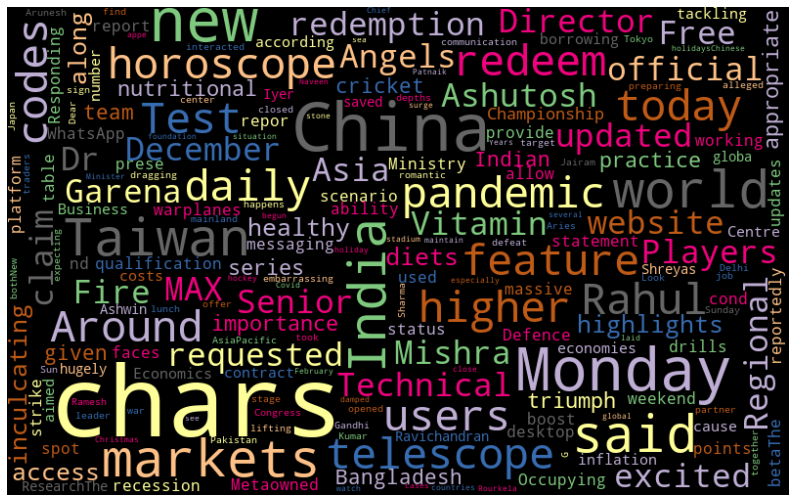

In [53]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Accent').generate(all_words)

    plt.figure(figsize=(14, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

#generate with pos sentiment content
all_words = ' '.join([text for text in df['content1'][df.sentiment == 'pos']])
generate_wordcloud(all_words)

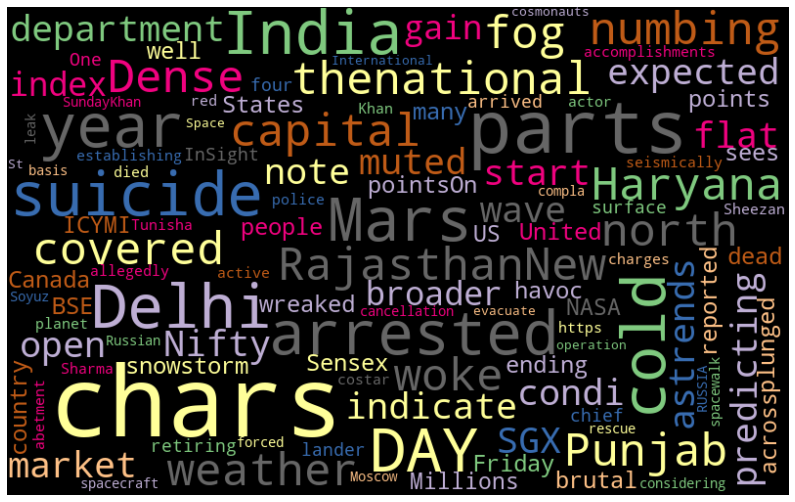

In [54]:
#generate with neg sentiment content
all_words = ' '.join([text for text in df['content1'][df.sentiment == 'neg']])
generate_wordcloud(all_words)

In [55]:
# create dictionary
dictionary = corpora.Dictionary(df['key_phrases'])
print(dictionary.num_nnz)

63


**CREATE DOCUMENT TERM MATRIX**

In [56]:
# create document term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in df['key_phrases']]

**INSTANTIATE LDA MODEL**

In [57]:
lda = gensim.models.ldamodel.LdaModel

**FIT LDA MODEL ON THE DATASET**

In [58]:
num_topics = 3
%time ldamodel = lda(doc_term_matrix, num_topics= num_topics,id2word=dictionary,passes=50, minimum_probability=0)

CPU times: user 359 ms, sys: 22.8 ms, total: 382 ms
Wall time: 358 ms


**PRINT THE TOPICS IDENTIFIED BY LDA MODEL**

In [59]:
ldamodel.print_topics(num_topics=num_topics)

[(0,
  '0.034*"surface mars one chief accomplishments" + 0.034*"bothnew delhi congress leader jairam ramesh sunday" + 0.034*"red planet" + 0.034*"mars insight lander four years" + 0.034*"icymi nasa" + 0.034*"rahul gandhi" + 0.034*"rahul g chars" + 0.034*"china pakistan" + 0.034*"depths dragging target lunch chars" + 0.034*"embarrassing defeat"'),
 (1,
  '0.032*"india" + 0.032*"dense fog" + 0.032*"numbing cold weather department" + 0.032*"thenational capital haryana punjab parts rajasthannew delhi delhi parts" + 0.032*"cold wave condi chars" + 0.032*"job offer communication romantic partner" + 0.032*"aries daily horoscope dear" + 0.032*"sun sign daily horoscope" + 0.032*"arunesh kumar sharma" + 0.032*"warplanes used china strike drills"'),
 (2,
  '0.031*"occupying" + 0.031*"spot points table prese chars" + 0.031*"world test championship qualification scenario massive" + 0.031*"russia days leak soyuz spacecraft" + 0.031*"day actor tunisha sharma" + 0.031*"costar sheezan khan charges abet

**FEATURE EXTRACTION FROM THE CONTENTS**

In [60]:
#KEY WORDS - POSITIVE PREDICTIONS

# BOW features
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(df['content1'])

# TF-IDF features
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(df['content1'])

In [61]:
#KEY PHRASES - NEGATIVE PREDICTIONS

phrase_sents = df['key_phrases'].apply(lambda x: ' '.join(x))

# BOW phrase features
bow_phrase_vectorizer = CountVectorizer(max_df=0.90, min_df=2)
bow_phrase_feature = bow_phrase_vectorizer.fit_transform(phrase_sents)

# TF-IDF phrase feature
tfidf_phrase_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2)
tfidf_phrase_feature = tfidf_phrase_vectorizer.fit_transform(phrase_sents)

In [62]:
target_variable = df['sentiment'].apply(lambda x: 0 if x=='neg' else 1)

**MODEL**

In [63]:
def plot_confusion_matrix(matrix):
    plt.clf()
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Set2_r)
    classNames = ['Positive', 'Negative']
    plt.title('Confusion Matrix')
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TP','FP'], ['FN', 'TN']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(matrix[i][j]))
    plt.show()

In [64]:
def naive_model(X_train, X_test, y_train, y_test):
    naive_classifier = GaussianNB()
    naive_classifier.fit(X_train.toarray(), y_train)

    # predictions over test set
    predictions = naive_classifier.predict(X_test.toarray())

    # calculating Accuracy Score
    print(f'Accuracy Score - {accuracy_score(y_test, predictions)}')
    conf_matrix = confusion_matrix(y_test, predictions, labels=[True, False])
    plot_confusion_matrix(conf_matrix)

**PREDICTION ON KEY WORD**

Accuracy Score - 0.6666666666666666


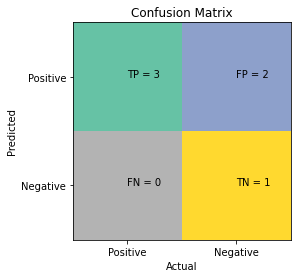

In [65]:
X_train, X_test, y_train, y_test = train_test_split(bow_word_feature, target_variable, test_size=0.3, random_state=200)
naive_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.6666666666666666


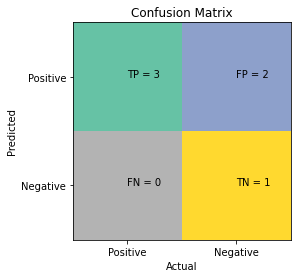

In [66]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_word_feature, target_variable, test_size=0.3, random_state=200)
naive_model(X_train, X_test, y_train, y_test)

**PREDICTION ON KEY PHRASES**

Accuracy Score - 0.6666666666666666


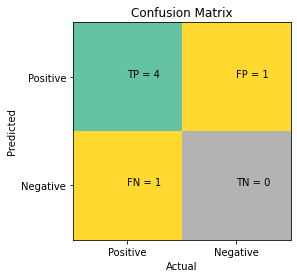

In [67]:
X_train, X_test, y_train, y_test = train_test_split(bow_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)

Accuracy Score - 0.6666666666666666


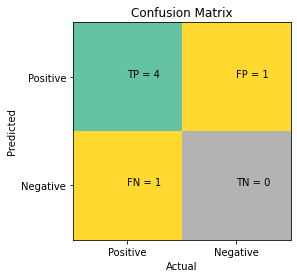

In [68]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_phrase_feature, target_variable, test_size=0.3, random_state=272)
naive_model(X_train, X_test, y_train, y_test)